#Problem Overview

Instacart is an American company that provides grocery delivery and pick-up service.The goal of the competition is to predict which products will be in a user's next order. So it predicts which previously products will be in the users next order

In this problem we are not recommending new products to the user instead of that we are going to recommend the products which is previously bought by the user. It is interesting problem because here we need to find the users rendered behaviour so we can personalized the user's crt

#Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from datetime import datetime

#A Glimpse of the Dataset

In [3]:
order_products_train_df=pd.read_csv('order_products__train.csv')
order_products_prior=pd.read_csv('order_products__prior.csv')
orders=pd.read_csv('orders.csv')
aisles=pd.read_csv('aisles.csv')
departments=pd.read_csv('departments.csv')
products=pd.read_csv('products.csv')
submission=pd.read_csv('sample_submission.csv')

###orders - It consists of order details placed by any user

*   Order_id : Unique for every order
*   User_id : Unique for every user
*   Eval_set : ( prior / train / test)
*   Order_number : ith order placed by user
*   Order_dow : Day of week
*   Order_hour_of_day : Time of day in hr
*   Days_since_prior_order : difference in days between 2 orders



In [4]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
orders.shape

(3421083, 7)

### order_products__prior — consists of all product details for any prior order

*   order_id : Unique order id for every order
*   product_id : product ID of item
*   add_to_cart_order : denotes the sequence in which products were added to cart.
*   reordered : product is reordered






In [6]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [8]:
order_products_prior.shape

(32434489, 4)

###department — details of department
*   department_id : product ID of item
*   department_name : name of department

In [9]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


###Aisles — details of aisles
*   aisle_id : aisle ID of item
*   aisle_name : name of aisle

In [10]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [11]:
aisles.shape

(134, 2)

###products — details of a product
*   product_id : product ID of item
*   product_name : name of product
*   aisle_id : aisle id of the product
*   department_id : department id of the product

In [12]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [13]:
products.shape

(49688, 4)

#EDA

Let's look at the distribution of train test and prior

In [14]:
countSet = orders['eval_set'].value_counts()
countSet

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

C:\Users\jyoti\anaconda3\envs\yourenvname\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


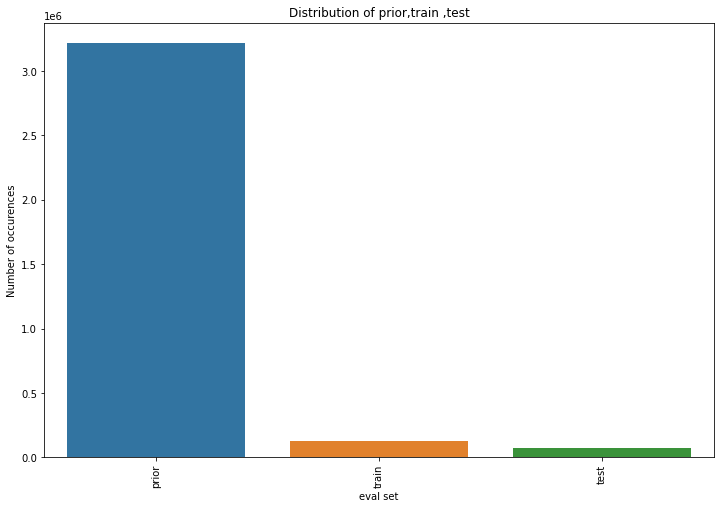

In [15]:
plt.figure(figsize=(12,8))
sns.barplot(countSet.index,countSet.values,)
plt.ylabel('Number of occurences')
plt.xlabel('eval set')
plt.title('Distribution of prior,train ,test')
plt.xticks(rotation='vertical')
plt.show()

Let's find the unique number of users

In [16]:
countSrs=orders.groupby('eval_set')['user_id'].agg(['nunique'])
countSrs

,nunique
eval_set,
prior,206209
test,75000
train,131209


#What is the Frequency of Order Number Amongst the users ?

C:\Users\jyoti\anaconda3\envs\yourenvname\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


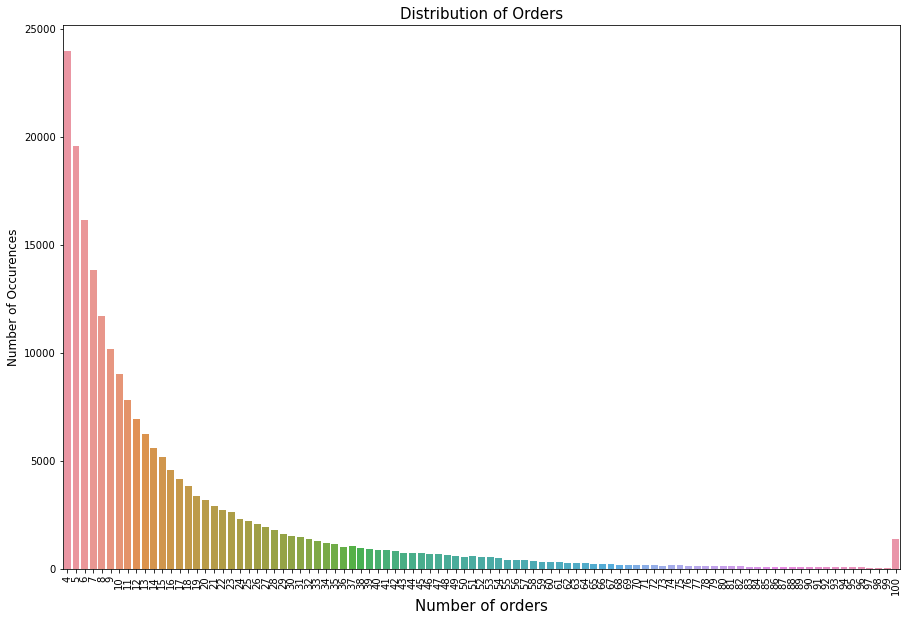

In [17]:
countOrder=orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
countOrder=countOrder.order_number.value_counts()
plt.figure(figsize=(15,10))
sns.barplot(countOrder.index,countOrder.values)
plt.ylabel('Number of Occurences',fontsize=12)
plt.xlabel('Number of orders',fontsize=15)
plt.title('Distribution of Orders',fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

As per the barplot, Maximum time number of orders are 4 for each users. There are some users who has 100 number of orders.

#What Day Of The Week User Placed The Order?

C:\Users\jyoti\anaconda3\envs\yourenvname\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


([<matplotlib.axis.XTick at 0x11280d2d3a0>,
 [Text(0, 0, 'Saturday'),
  Text(1, 0, 'Sunday'),
  Text(2, 0, 'Monday'),
  Text(5, 0, 'Tuesday'),
  Text(6, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday')])

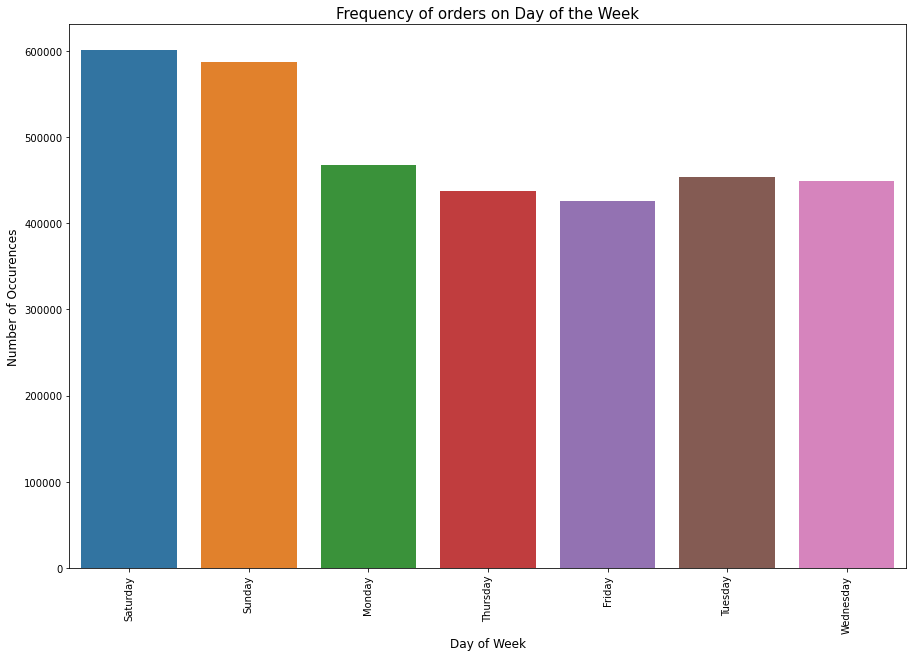

In [18]:
countDow=orders['order_dow'].value_counts()
label=['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
plt.figure(figsize=(15,10))
sns.barplot(countDow.index,countDow.values)
plt.ylabel('Number of Occurences',fontsize=12)
plt.xlabel('Day of Week',fontsize=12)
plt.title('Frequency of orders on Day of the Week',fontsize=15)
plt.xticks(ticks=countDow.index,labels=label,rotation='vertical')

There are 7 days in a week most of the time user placed order on that starting days of the week i.e is on Saturday and Sunday where most of the users are free on that day and have time to place the orders
Since after two days of the week frequency decreased a bit

#In which Hour user place order ?

C:\Users\jyoti\anaconda3\envs\yourenvname\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


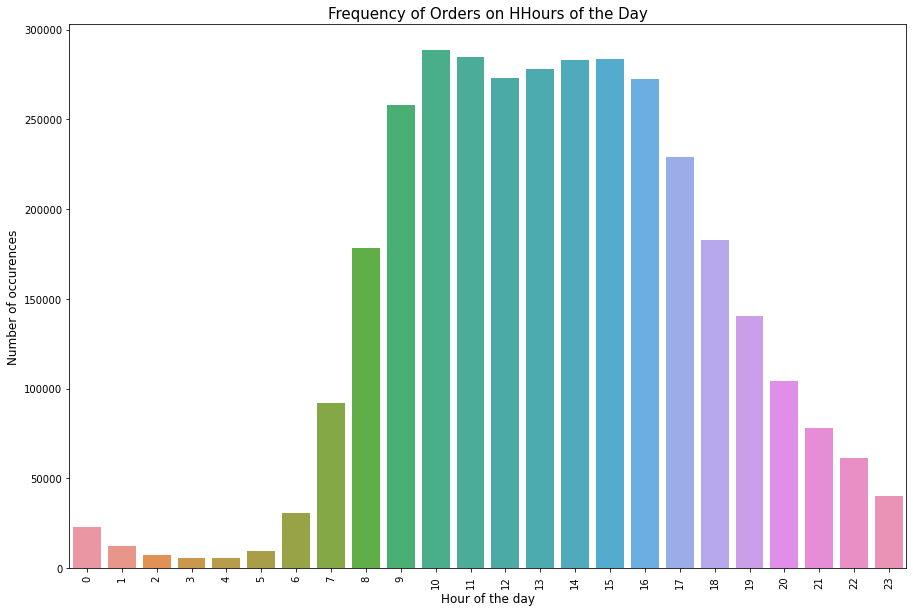

In [19]:
countHour=orders['order_hour_of_day'].value_counts()
plt.figure(figsize=(15,10))
sns.barplot(countHour.index,countHour.values)
plt.ylabel('Number of occurences',fontsize=12)
plt.xlabel('Hour of the day',fontsize=12)
plt.title('Frequency of Orders on Hours of the Day',fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

The maximum number of order are placed between 10 and 15 hour of the day

#After the last purchase How many days the user takes to place the order?

C:\Users\jyoti\anaconda3\envs\yourenvname\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


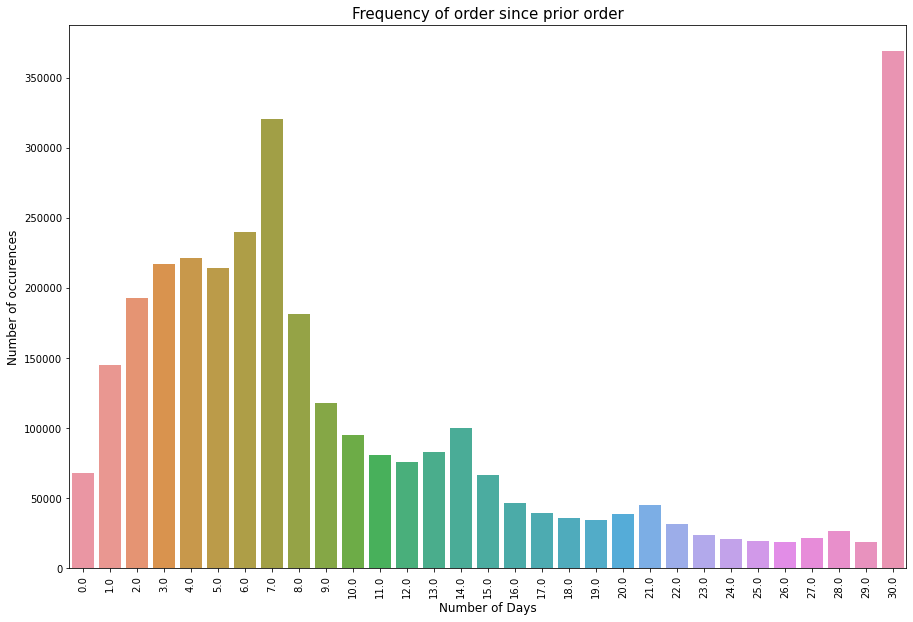

In [20]:
countPriorOrder=orders['days_since_prior_order'].value_counts()
plt.figure(figsize=(15,10))
sns.barplot(countPriorOrder.index,countPriorOrder.values)
plt.ylabel('Number of occurences',fontsize=12)
plt.xlabel('Number of Days',fontsize=12)
plt.title('Frequency of order since prior order',fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

This chart tells us that most of the users place order once in weeks because there is high peak at 7th day and 14th day and 30th day

#How Many Unique Products and Department in the Data?

How many unique Products are in the Data?

In [21]:
print(f'Unique Number of products :{len(products.product_name.unique())}')

Unique Number of products :49688


How many unique Department in the data

In [22]:
print(f'unique Department in the data :{len(departments.department.unique())}')

unique Department in the data :21


How many unique Aisle in the Data?

In [23]:
print(f'unique Department in the Aisle :{len(aisles.aisle.unique())}')

unique Department in the Aisle :134


###Merge the dataFrame
This can be done by using the Primary ID's of the Products ,Aisle and Department and explore the behavioir of customers towards their orders

In [24]:
df=pd.merge(order_products_prior,products,on=['product_id','product_id'])
df = pd.merge(df,aisles,on=['aisle_id','aisle_id'])
df = pd.merge(df,departments,on=['department_id','department_id'])
df = pd.merge(df,orders,on=['order_id','order_id'])
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,17794,6,1,Carrots,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
3,2,43668,9,0,Classic Blend Cole Slaw,123,4,packaged vegetables fruits,produce,202279,prior,3,5,9,8.0
4,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0


###How Oftern User reorder the same item?


C:\Users\jyoti\anaconda3\envs\yourenvname\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


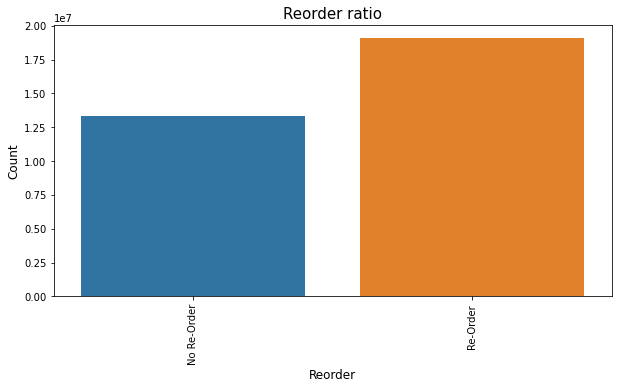

In [25]:
reOrderRatio=order_products_prior['reordered'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(reOrderRatio.index,reOrderRatio.values)
plt.ylabel('Count',fontsize=12)
plt.xlabel('Reorder',fontsize=12)
plt.title('Reorder ratio',fontsize=15)
plt.xticks(ticks=reOrderRatio.index,labels=['Re-Order','No Re-Order'],rotation='vertical')
plt.show()

#Top Selling Products

In [26]:
pr_count = df["product_id"].value_counts().to_frame()
pr_count["count"] = pr_count.product_id
pr_count["product_id"] = pr_count.index
pr_merge = pd.merge(pr_count,products,how="left",on="product_id").sort_values(by="count",ascending=False)
pr_merge= pr_merge.drop(['aisle_id','department_id'],axis=1)

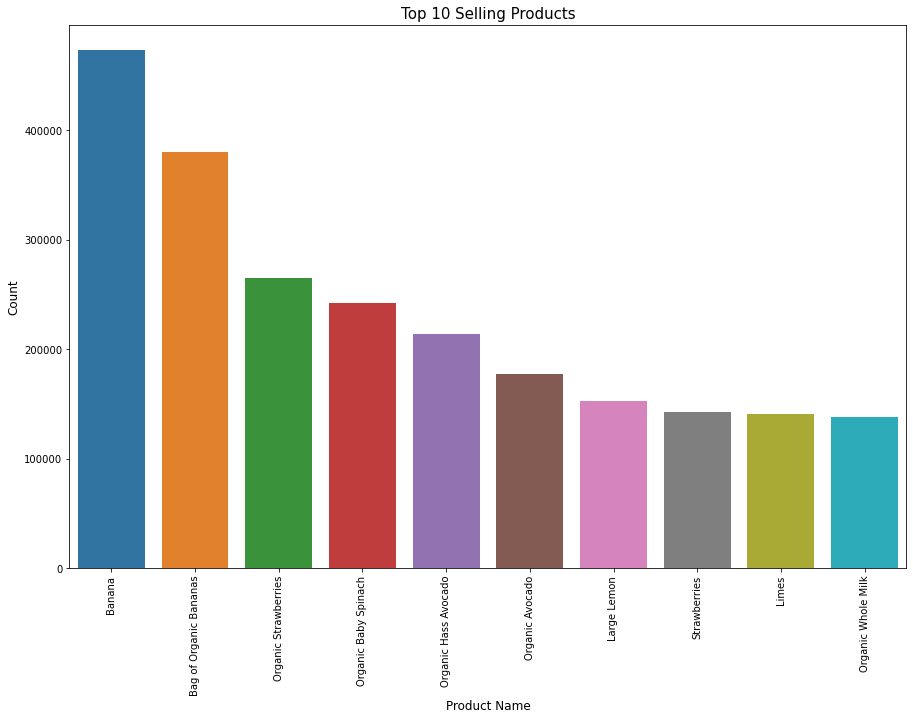

In [27]:
plt.figure(figsize=(15,10))
sns.barplot(data=pr_merge.head(10),x='product_name',y='count')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Product Name', fontsize=12)
plt.title('Top 10 Selling Products', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

This are the top 100 selling products. The most selling product is Banana and Organic Banana Chips.

#Top 100 Reorderd Products

In [28]:
a=df[df['reordered']==1]['product_id'].value_counts().to_frame()
a['reorder_count'] = a.product_id
a['product_id'] = a.index
reorder = pd.merge(a,products,on='product_id',how='left').sort_values(by="reorder_count",ascending=False)
reorder= reorder.drop(['aisle_id','department_id'],axis=1)

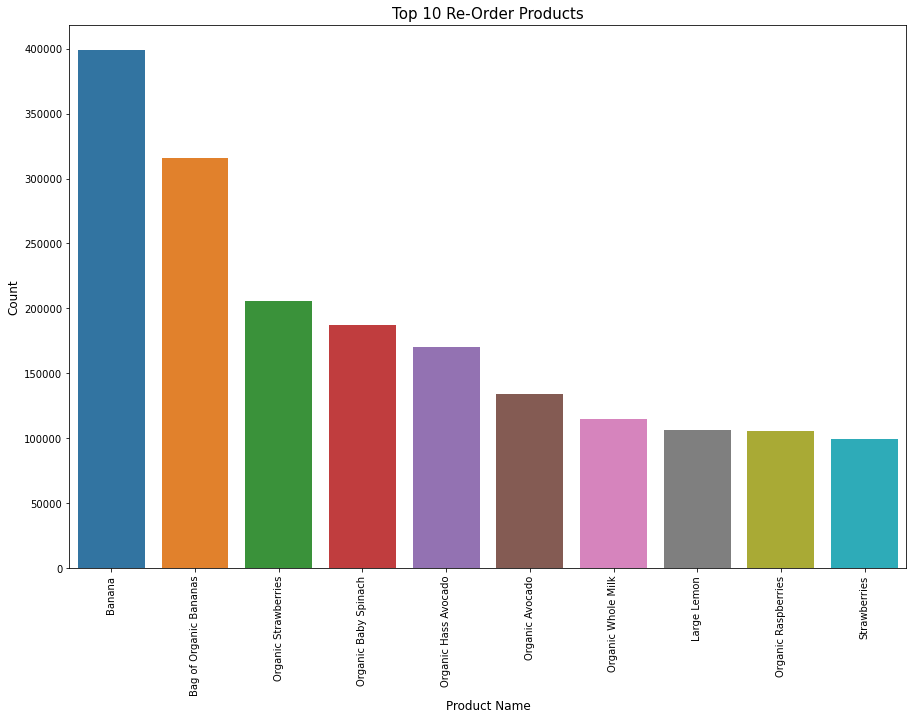

In [29]:
plt.figure(figsize=(15,10))
sns.barplot(data=reorder.head(10),x='product_name',y='reorder_count')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Product Name', fontsize=12)
plt.title('Top 10 Re-Order Products', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()


The top 100 selling products and Top 100 reorder products barplot is almost same.
There is high peak on banana and oraganic banana chips looks like that that is most loving product and reorder products among users

#Which Item User Add to Cart First?

In [30]:
first_order = order_products_prior[order_products_prior['add_to_cart_order']==1]['product_id'].value_counts().to_frame()
first_order['count'] = first_order.product_id
first_order['product_id'] = first_order.index
order = pd.merge(first_order,products,on='product_id',how='left').sort_values(by="count",ascending=False)
order = order.drop(['aisle_id','department_id'],axis=1)

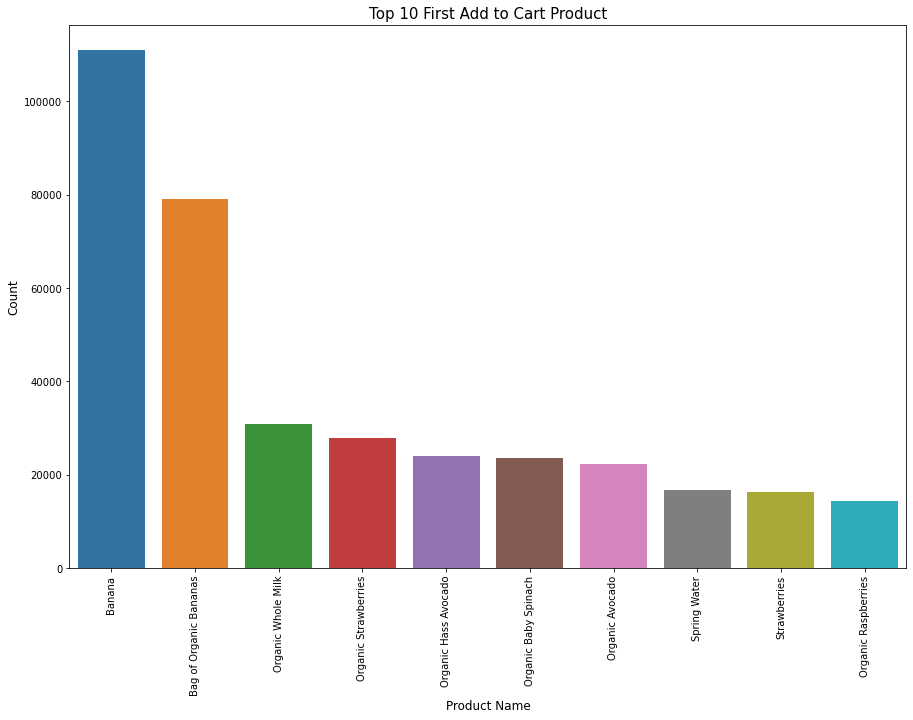

In [31]:
plt.figure(figsize=(15,10))
sns.barplot(data=order.head(10),x='product_name',y='count')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Product Name', fontsize=12)
plt.title('Top 10 First Add to Cart Product', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

If you see above 3 plots, all plots are almost same.
Top selling,reordered and First product add to cart order product is Banana.
From all this plot, the demand for produce product are high than any other Department,

#Top Departments

In [32]:

depart = df['department_id'].value_counts().to_frame()
depart['count'] = depart['department_id']
depart['department_id'] = depart.index
dep_merge = pd.merge(depart,departments,on='department_id',how='left').sort_values(by='count',ascending=False)

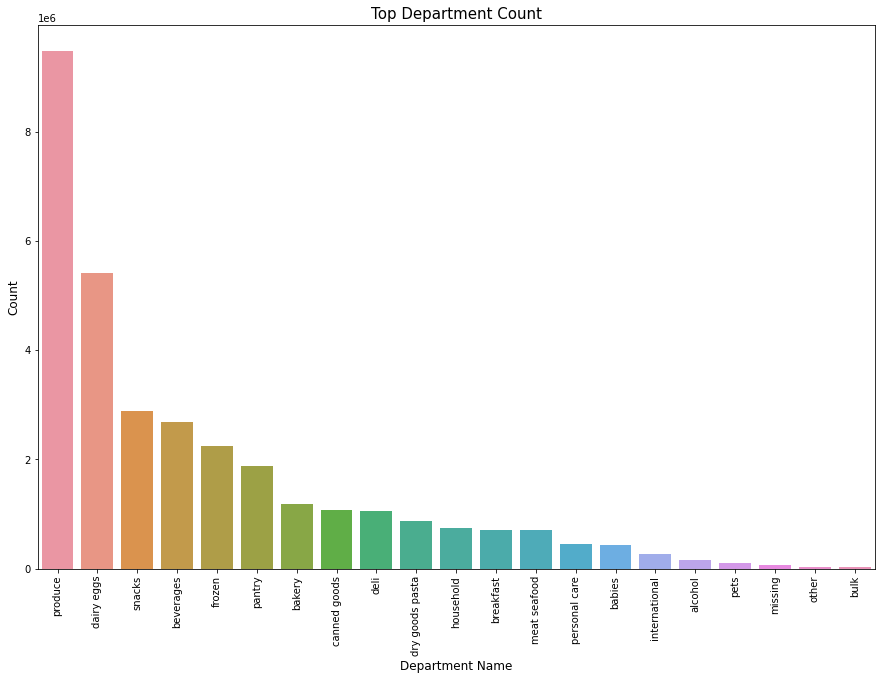

In [33]:
plt.figure(figsize=(15,10))
sns.barplot(data=dep_merge,x='department',y='count')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Department Name', fontsize=12)
plt.title('Top Department Count', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

The First 2 Department have very high peak than any other department.
As the First 2 Department are most important for any users because the Prodcue Department are about farm,crops and fruits and eggs are essiental the breakfast.

In [34]:
orde = pd.merge(orders,order_products_prior,on='order_id',how='left')
orde.head(1)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196.0,1.0,0.0


#At What Time User Place Order Again?

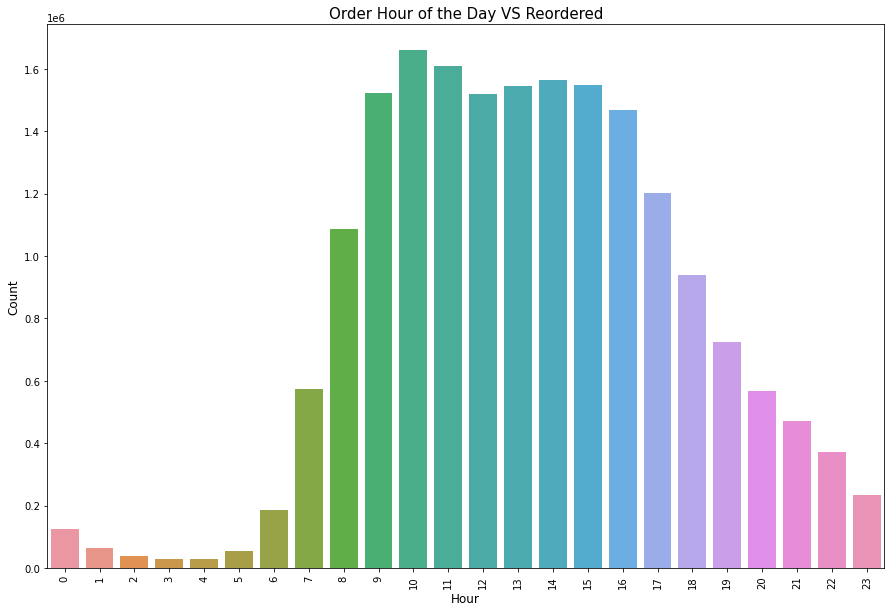

In [35]:
a = orde[orde['reordered']==1]['order_hour_of_day'].value_counts().to_frame()
a['reorder_count'] = a.order_hour_of_day
a['hours'] = a.index

plt.figure(figsize=(15,10))
sns.barplot(data=a,x='hours',y='reorder_count')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour', fontsize=12)
plt.title('Order Hour of the Day VS Reordered', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

Here I plot at what time most reordered products are placed. Most of the orders are placed between 8'0 clock in the morning and 5'0 clock in the evening.
This plot is almost same as Frequency of the order day. It shows user tends to order/reorder between this hours. This feature could help to predict reorder.

#At What Day Most User Place Order Again?

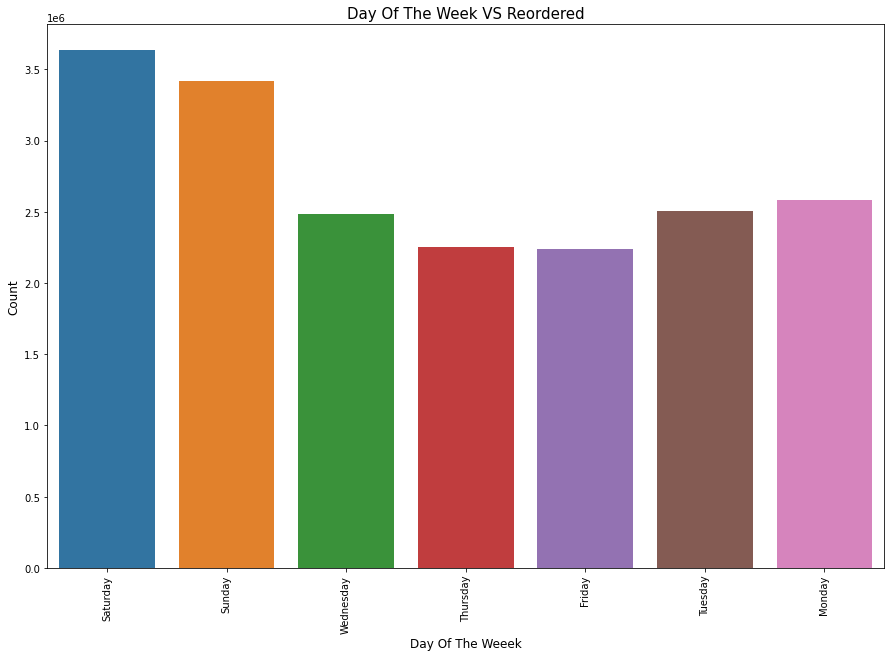

In [36]:
a = orde[orde['reordered']==1]['order_dow'].value_counts().to_frame()
a['reorder_count'] = a.order_dow
a['dow'] = a.index
label = ['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']

plt.figure(figsize=(15,10))
sns.barplot(data=a,x='dow',y='reorder_count')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day Of The Weeek', fontsize=12)
plt.title('Day Of The Week VS Reordered', fontsize=15)
plt.xticks(rotation='vertical',ticks=a.index,labels=label)
plt.show()

The Order and Re-Order ration are almost same. The user tends to place order again on Saturday and Sunday.
This Feature tells us that Saturday and Sunday have the high ratio of Order/Re-Order getting placed.

#Add To Cart Order VS Reordered

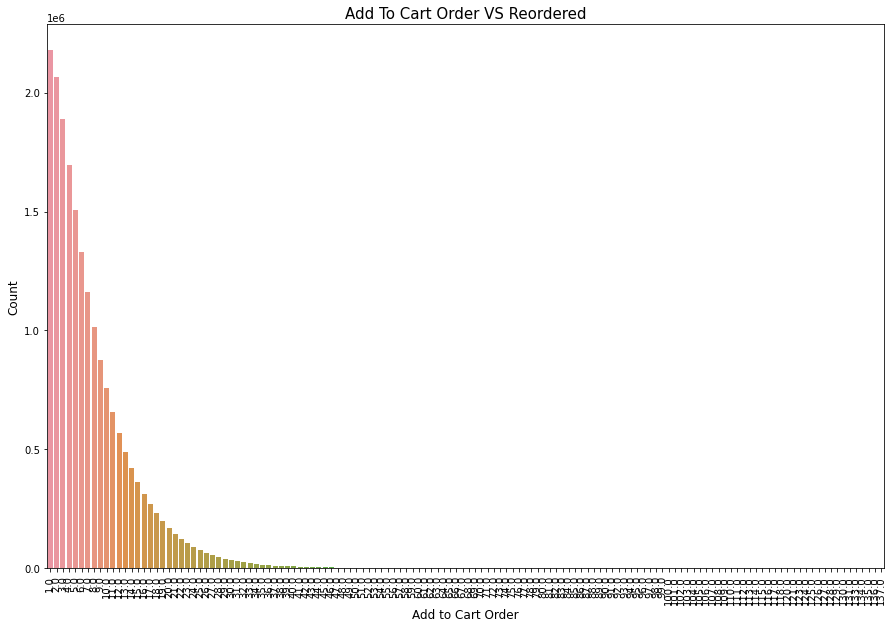

In [37]:
a = orde[orde['reordered']==1]['add_to_cart_order'].value_counts().to_frame()
a['reorder_count'] = a.add_to_cart_order
a['order_number'] = a.index

plt.figure(figsize=(15,10))
sns.barplot(data=a,x='order_number',y='reorder_count')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Add to Cart Order', fontsize=12)
plt.title('Add To Cart Order VS Reordered', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

The order which are added at 1th and 4th position in the cart have high chance of Re-Order by users.

This Distrubtion looks like Power Law which states 80% of Re-Order are between 1 to 15th position in the cart.


#Reorder Ratio of Day of the Week Vs Hour of the Day

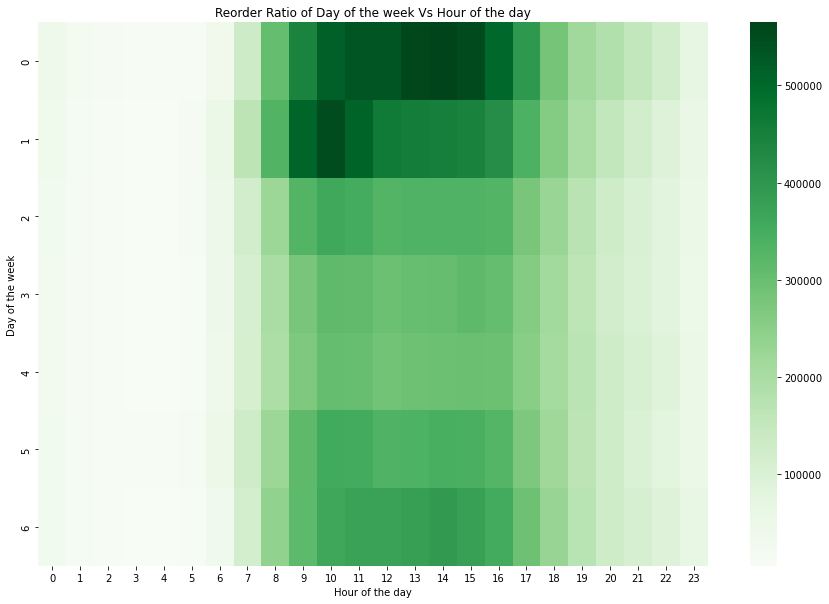

In [38]:
grp = orde.groupby(['order_dow','order_hour_of_day'])['reordered'].aggregate('count').reset_index()
grp = grp.pivot(index='order_dow',columns='order_hour_of_day',values='reordered')
plt.figure(figsize=(15,10))
sns.heatmap(grp,cmap='Greens')
plt.title("Reorder Ratio of Day of the week Vs Hour of the day")
plt.xlabel('Hour of the day')
plt.ylabel('Day of the week')
plt.show()

This Heatmap tells everything, Lot of users place order on Saturday and Sunday in between 10'clock to 15'clock.
This Feature helpful for user beaviour and also for reorder.

In [39]:

df = pd.merge(order_products_prior,products,on=['product_id','product_id'])

df = pd.merge(df,departments,on=['department_id','department_id'])

df = pd.merge(df,orders,on=['order_id','order_id'])
df.head(1)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs,202279,prior,3,5,9,8.0


#Top Reordered Department

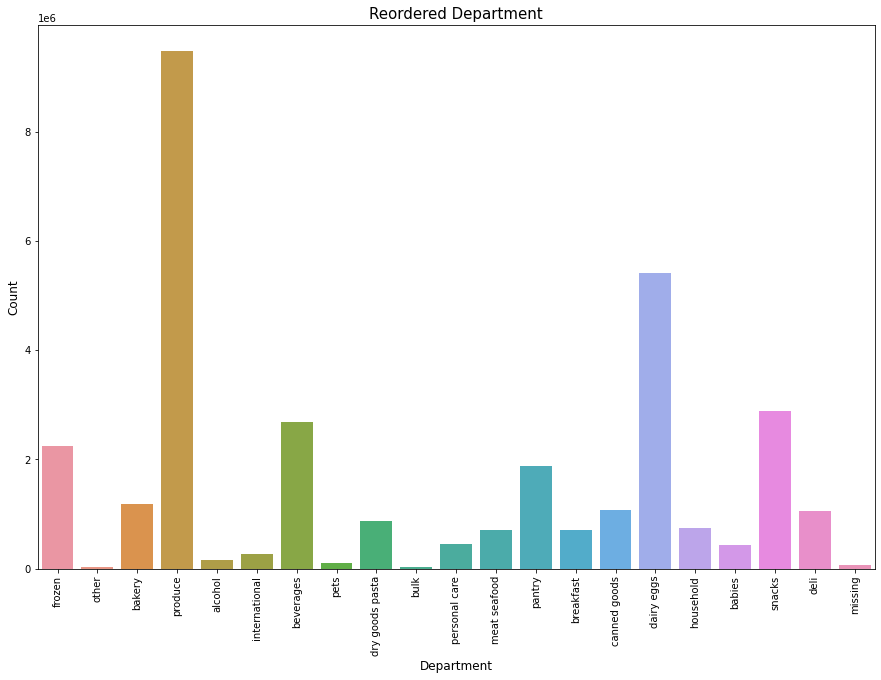

In [40]:

grp = df.groupby(['department_id','department'])['reordered'].aggregate('count').reset_index()
grp['reorder_count'] = grp.reordered
grp['dept'] = grp.department

plt.figure(figsize=(15,10))
sns.barplot(data=grp,x='dept',y='reorder_count')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title('Reordered Department', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

Most Users reorder from Produce and Dairy Eggs Department as they are essential for every day that's why they have high peak than any other department.

The reason I have not done Pairplot and Correlation Between the features, there are lot of features in the data and here the task in the EDA is to understand user bheaviour.There are lot of features have same distribution in the case of order and reorder ratio and that makes them useful for the task.